## [**一、数据处理部分**](#step1)
- [**1. 原始json文件转换为csv文件**](#step11) 	

- [**2. 滤波（中值、低通）**](#step12) 

- [**3. 分离人体/重力加速度**](#step13) 

- [**4. 提取特征**](#step14) 

- [**5. 训练模型**](#step14) 

### 1. 原始json文件转换为csv文件


动作1： 22 动作2： 19 动作3： 18 动作4： 18
拥有样本数： 77


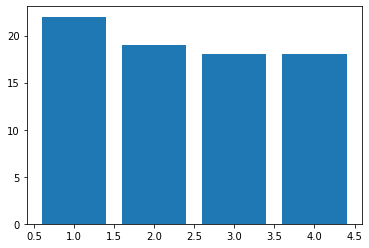

In [8]:
import json
import csv
import matplotlib.pyplot as plt

# 1. 创建文件对象
new_activity = open("./raw_csv/new_activity.csv", 'w', encoding='utf-8', newline='')
# 2. 基于文件对象构建 csv写入对象
csv_writer = csv.writer(new_activity)
# 3. 构建列表头
csv_writer.writerow(["accx", "accy", "accz", "gryx", "gryy", "gryz", "number", "activity"])

record = 0      # 拥有的动作记录总数
a1 = 0
with open("./raw_json/activity1.json", 'r', encoding="utf-8") as f:
    for jsonstr in f.readlines():
        dict_json = json.loads(jsonstr)
        if (dict_json['accx'] != [] and dict_json['accy'] != [] and dict_json['accz'] != [] and
            dict_json['gryx'] != [] and dict_json['gryy'] != [] and dict_json['gryz'] != []):
            record += 1
            a1 += 1
            for i in range(20, 70):
                csv_writer.writerow([dict_json['accx'][i], dict_json['accy'][i], dict_json['accz'][i], dict_json['gryx'][i], dict_json['gryy'][i], dict_json['gryz'][i], dict_json['number'], '1'])

a2 = 0
with open("./raw_json/activity2.json", 'r', encoding="utf-8") as f:
    for jsonstr in f.readlines():
        dict_json = json.loads(jsonstr)
        if (dict_json['accx'] != [] and dict_json['accy'] != [] and dict_json['accz'] != [] and
            dict_json['gryx'] != [] and dict_json['gryy'] != [] and dict_json['gryz'] != []):
            record += 1
            a2 += 1
            for i in range(20, 70):
                csv_writer.writerow([dict_json['accx'][i], dict_json['accy'][i], dict_json['accz'][i], dict_json['gryx'][i], dict_json['gryy'][i], dict_json['gryz'][i], dict_json['number'], '2'])

a3 = 0
with open("./raw_json/activity3.json", 'r', encoding="utf-8") as f:
    for jsonstr in f.readlines():
        dict_json = json.loads(jsonstr)
        if (dict_json['accx'] != [] and dict_json['accy'] != [] and dict_json['accz'] != [] and
            dict_json['gryx'] != [] and dict_json['gryy'] != [] and dict_json['gryz'] != []):
            record += 1
            a3 += 1
            for i in range(20, 70):
                csv_writer.writerow([dict_json['accx'][i], dict_json['accy'][i], dict_json['accz'][i], dict_json['gryx'][i], dict_json['gryy'][i], dict_json['gryz'][i], dict_json['number'], '3'])

a4 = 0
with open("./raw_json/activity4.json", 'r', encoding="utf-8") as f:
    for jsonstr in f.readlines():
        dict_json = json.loads(jsonstr)
        if (dict_json['accx'] != [] and dict_json['accy'] != [] and dict_json['accz'] != [] and
            dict_json['gryx'] != [] and dict_json['gryy'] != [] and dict_json['gryz'] != []):
            record += 1
            a4 += 1
            for i in range(20, 70):
                csv_writer.writerow([dict_json['accx'][i], dict_json['accy'][i], dict_json['accz'][i], dict_json['gryx'][i], dict_json['gryy'][i], dict_json['gryz'][i], dict_json['number'], '4'])

print("动作1：", a1, "动作2：", a2, "动作3：", a3, "动作4：", a4)
print("拥有样本数：", record)
new_activity.close() 

plt.bar([1, 2, 3, 4], [a1, a2, a3, a4], label='动作数')

plt.show()

### 2. 滤波（中值、低通） + 分离人体/重力加速度
### 3. 提取特征

In [9]:
import numpy as np
import pandas as pd
from filter import filter_func, components_selection_one_signal
# 提取特征
from extract_feature import feature_core

# 把所有动作记录存入同一个字典
all_data = pd.read_csv("./raw_csv/new_activity.csv")
raw_dic = {}
for i in range(0, 77):
    data = all_data.loc[i*50:i*50+49, :]        # 3s: 50个数据
    data = pd.DataFrame(data)
    key = i+1
    raw_dic[key] = data


# 建立新dic（分离了人体、重力）
new_dic = {}
new_columns = ['t_body_accx', 't_body_accy', 't_body_accz',   # 10个分量
                       't_grav_accx', 't_grav_accy', 't_grav_accz',
                       't_body_gryx', 't_body_gryy', 't_body_gryz', 'number', 'activity']
for key in range(1, 78):
    raw_df = raw_dic[key]
    time_sig_df = pd.DataFrame()  # 每条记录一个新DataFrame

    for column in raw_df.columns:  # 旧列名
        # 遍历每一列
        t_signal = np.array(raw_df[column])
        med_filtred = filter_func(t_signal)
        if 'acc' in column:  # acc列(x,y,z)
            _, grav_acc, body_acc, _ = components_selection_one_signal(med_filtred)
            time_sig_df['t_body_' + column] = body_acc[:]
            time_sig_df['t_grav_' + column] = grav_acc[:]

        elif 'gry' in column:  # gry列(x,y,z)
            _,_,body_gyro,_=components_selection_one_signal(med_filtred)
            time_sig_df['t_body_'+column] = body_gyro[:]

    time_sig_df['number'] = np.array(raw_df['number'])    # 次数
    time_sig_df['activity'] = np.array(raw_df['activity'])  # 次数
    t_signal = np.array(raw_df['number'])
    ordered_time_sig_df = pd.DataFrame()
    for col in new_columns:
        ordered_time_sig_df[col] = time_sig_df[col]

    new_dic[key] = ordered_time_sig_df


# 提取特征
all_feature = pd.DataFrame()
for i in range(1, 78):
    feature_ = pd.DataFrame()
    for j in [0, 1, 2, 6, 7, 8]:
        column = new_columns[j]
        data = np.array(new_dic[i][column]).reshape(50, 1)
        a = feature_core.sequence_feature(data, 32, 16)     # 19列特征  shape:(3,19)
        data1 = pd.DataFrame(a)
        feature_ = pd.concat([feature_, data1], axis=1)     # 横向连接19个feature
    feature_['gra_x'] = np.full(feature_.shape[0], new_dic[i]['t_grav_accx'][0])
    feature_['gra_y'] = np.full(feature_.shape[0], new_dic[i]['t_grav_accy'][0])
    feature_['gra_z'] = np.full(feature_.shape[0], new_dic[i]['t_grav_accz'][0])
    feature_['number'] = np.full(feature_.shape[0], int(new_dic[i]['number'][0]/5))
    feature_['activity'] = np.full(feature_.shape[0], new_dic[i]['activity'][0])
    all_feature = pd.concat([all_feature, feature_], axis=0)     # 纵向连接不同记录
print(all_feature)


all_feature.to_csv("./extract_feature/feature.csv", index=False,header=None)

           0         1         2         3         4         5     6  \
0  -0.027955  0.027992  0.167309 -0.319466  0.186107 -0.319466  17.0   
1   0.023147  0.023230  0.152414 -0.252696  0.250503 -0.252696  21.0   
2   0.049697  0.037356  0.193277 -0.252696  0.328154 -0.252696  12.0   
0   0.035426  0.115473  0.339813 -0.611118  0.481536 -0.611118  20.0   
1   0.108641  0.129192  0.359432 -0.665126  0.574245 -0.665126  21.0   
..       ...       ...       ...       ...       ...       ...   ...   
1  -0.036863  0.047951  0.218978 -0.358327  0.456734 -0.358327  10.0   
2   0.002047  0.053210  0.230674 -0.224993  0.496661 -0.224993   5.0   
0   0.036956  0.095112  0.308403 -0.440334  0.634951 -0.440334  13.0   
1  -0.022617  0.046672  0.216037 -0.413439  0.353834 -0.413439  13.0   
2  -0.065700  0.028051  0.167485 -0.355529  0.245555 -0.355529   6.0   

           7         8         9  ...        14        15        16        17  \
0   0.505573  0.229558  5.924744  ...  0.095329  0.005

### 4.随机森林训练模型

In [10]:
import numpy as np
import pandas as pd
# 训练
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import train_test_split     # 将数据分为测试集和训练集
import joblib
np.random.seed(100)

all_feature = pd.read_csv("./extract_feature/feature.csv")
all_feature = np.array(all_feature)
print(all_feature)

# 利用train_test_split进行将训练集和测试集进行分开，test_size占30%
X_train, X_test, y_train, y_test = train_test_split(all_feature[:, :-2], all_feature[:, -1], test_size=0.3)  
rfc = RandomForestClassifier()  # 实例化
rfc = rfc.fit(X_train, y_train)  # 用训练集数据训练模型
result = rfc.score(X_test, y_test)
print(result)

joblib.dump(rfc, "./forest.pkl")

[[ 0.02314718  0.02322992  0.15241364 ...  0.51946064  1.
   1.        ]
 [ 0.04969742  0.03735613  0.19327733 ...  0.51946064  1.
   1.        ]
 [ 0.03542649  0.1154732   0.33981348 ...  0.47936284  1.
   1.        ]
 ...
 [ 0.03695613  0.09511212  0.30840253 ...  0.86603427  3.
   4.        ]
 [-0.02261711  0.04667208  0.21603721 ...  0.86603427  3.
   4.        ]
 [-0.06569979  0.0280512   0.16748491 ...  0.86603427  3.
   4.        ]]
0.9130434782608695


['./forest.pkl']